# Kiwi Challenge 2018

## Deep Learning

## Model 3: Build a Lenet Architecture model using tensorflow.
## Convolutional Neural Networks

In this Notebook, all the steps are explained for a better understanding of the program, some additional code that does not appear in this Notebook, it will be found in the Python code. Details of this challengue can be found [here](https://github.com/KiwiCampusChallenge/Kiwi-Campus-Challenge/blob/master/Deep-Learning-Challenge.md), please before starting, you have to run the command **python app.py download** explained earlier in ** app.ipynb**

## Step 0: Read training Set or test Set from directory

In [1]:
import cv2
import time,random
import os,shutil
import urllib.request
import zipfile
import click
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from PIL import Image
from tensorflow.contrib.layers import flatten
NUM_CLASSES=43

def read_train_test_from_directory(path_dir):
    print("Reading data from: ",path_dir)
    Xtrain_test=[]
    Ytrain_test=[]
    for i in range(NUM_CLASSES):
        pathfile=path_dir+str(i)+"/"
        for file in os.listdir(pathfile):
            if os.path.isfile(os.path.join(pathfile, file)):
                Xtrain_test.append(np.array(Image.open(os.path.join(pathfile, file))))
                Ytrain_test.append(i)
    return np.array(Xtrain_test),np.array(Ytrain_test)

If we want to read the training data, we will call with the following command.

In [3]:
Xtrain,Ytrain=read_train_test_from_directory("images/train/")
print("Number of images: ",Xtrain.shape[0])
print("Dimensions of any images: ",Xtrain[12].shape)
print("Label class: ",Ytrain[87])

Reading data from:  images/train/
Number of images:  976
Dimensions of any images:  (25, 25, 3)
Label class:  2


in the same way that, with testSet

In [4]:
Xtest,Ytest=read_train_test_from_directory("images/test/")
print("Number of images: ",Xtest.shape[0])
print("Dimensions of any images: ",Xtest[67].shape)
print("Label class: ",Ytest[67])

Reading data from:  images/test/
Number of images:  237
Dimensions of any images:  (53, 53, 3)
Label class:  7


# Step 1: Transform Images and normalize

## Data Augmentation
The data presented is small, so it is advisable to increase the data artificially through some transformations.
We increase four times the data.

In [5]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .10 + np.random.uniform()/3.0
    image1[:, :, 2] = image1[:, :, 2] * random_bright
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image1


def transform_image(img):
    ang_range = 5
    ang_rot = np.random.uniform(ang_range) - ang_range / 2
    rows, cols, ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang_rot, 1)
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = augment_brightness_camera_images(img)
    return img


def data_augmentation(X, Y):
    x1=[]
    y1=[]
    for i in range(X.shape[0]):
        x1.append(X[i])
        y1.append(Y[i])
        for num in range(3):
            x1.append(transform_image(X[i]))
            y1.append(Y[i])
    return np.array(x1), np.array(y1)

For example if we have this image

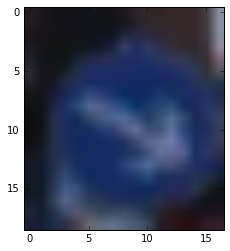

In [11]:
plt.imshow(Xtrain[888])
plt.show()

Some transformations of the previous image

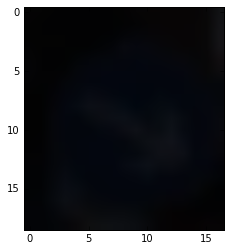

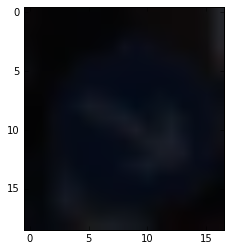

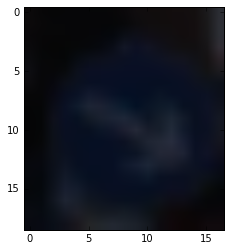

In [12]:
for i in range(3):
    plt.imshow(transform_image(Xtrain[888]))
    plt.show()

We can improve and make differents transformation,  (with this library) https://github.com/aleju/imgaug

# Feature Extraction
## Rescaling images and converts to grayscale
We resize the image to (32,32,3)
Every pixel in the image has values between [0,255], we normalize the data and transform to [-1,1]

In [13]:
def preprocess_data(X,Y):
    X_preprocess=[]
    num_of_images=X.shape[0]

    for i in range(num_of_images):
        X_preprocess.append(np.array(Image.fromarray(X[i]).resize((32, 32))))
    X_preprocess = np.array(X_preprocess)
    X_preprocess = X_preprocess.astype('float64')
    X_preprocess = (X_preprocess - 128.) / 128.

    images_gray = np.average(X_preprocess, axis=3)
    images_gray = np.expand_dims(images_gray, axis=3)
    y_onehot = np.zeros([Y.shape[0], NUM_CLASSES])

    for i in range(Y.shape[0]):
        y_onehot[i][int(Y[i])] = 1
    Y = y_onehot
    return images_gray,Y

# Step 2: Lenet Model - Tensorflow
Models will be saved in models/model3/saved/checkpoint

![Lenet](https://raw.githubusercontent.com/jonathandrnd/German-Traffic-Signs-Detector/master/screenshot/lenet.png)

In [28]:
def LeNet(x):
    #hyperparameters
    mu = 0
    sigma = 0.1
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    image_depth =1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Avg Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation.
    fc1 = tf.nn.relu(fc1)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation.
    fc2 = tf.nn.relu(fc2)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    return logits

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    accuracy = sess.run(accuracy_operation, feed_dict={X_data, y_data})
    return accuracy / num_examples

def lenet_tensorflow(dir_train_or_test,istraining,model=-1,Xinfer=None):
    EPOCHS = 500
    
    image_depth=1
    x = tf.placeholder(tf.float32, [None, 32, 32, image_depth],name="x")
    y = tf.placeholder(tf.float32, [None,43],name="y")

    rate = 0.003
    logits = LeNet(x)

    varss = tf.trainable_variables()
    lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in varss
                       if '_b' not in v.name]) * 0.0001
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy) + lossL2
    optimizer = tf.train.AdamOptimizer(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()
    cost_arr = []
    
    if not os.path.exists("models"):
        os.makedirs("models")
    if not os.path.exists("models/model3"):
        os.makedirs("models/model3")
    if not os.path.exists("models/model3/saved"):
        os.makedirs("models/model3/saved")

    if istraining==True:
        Xtrain, Ytrain = read_train_test_from_directory(dir_train_or_test)
        Xtrain, Ytrain = preprocess_data(Xtrain, Ytrain)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            print("Training...")
            for i in range(EPOCHS):
                to, cost = sess.run([training_operation, loss_operation], feed_dict={x:Xtrain, y:Ytrain})
                cost_arr.append(cost)
                pathglobal = os.getcwd() + "/models/model3/saved/lenet.ckpt"
                if (i+1)%50==0:
                    print("EPOCH; {} of {}; Loss; {:.5f}".format(i + 1, EPOCHS, cost))
                if i%100==0:
                    saver.save(sess, pathglobal, global_step=i + 1)
            saver.save(sess, pathglobal, global_step=i+1)
            print("Model saved")
    else:
        if model==-1:
            with tf.Session() as sess:
                pathglobal = os.getcwd() + "/models/model3/saved/"
                saver.restore(sess, tf.train.latest_checkpoint(pathglobal))
                Xtest, Ytest = read_train_test_from_directory(dir_train_or_test)
                Xtest, Ytest = preprocess_data(Xtest, Ytest)
                accuracy = sess.run(accuracy_operation, feed_dict={x: Xtest, y: Ytest})
                print("Test Accuracy = {:.3f}".format(accuracy))
        else:
            with tf.Session() as sess:
                pathglobal = os.getcwd() + "/models/model3/saved/"
                saver.restore(sess, tf.train.latest_checkpoint(pathglobal))
                _ =np.zeros([Xinfer.shape[0],43])
                accuracy = sess.run(logits, feed_dict={x: Xinfer, y: _})
                return np.argmax(accuracy,1)


I have commented #Xtrain, Ytrain = data_augmentation(Xtrain,Ytrain) but you can uncommented

## Training
To train the model use this command - **python app.py train -m model3 -d images/train**

In [18]:
def train(m, d):
    print("Training Phase")
    if d[-1]!='/':
        d=d+"/"

    if not os.path.exists("data/FullIJCNN2013/"):
        print("Please use first the next command (python app.py download)")
        return

    if m=="model1":
        print("Task3: Logistic Regresion - Scikit")
        logistic_regression_scikit(d,True)

    if m=="model2":
        print("Task4: Logistic Regresion - Tensorflow")
        logistic_regression_tensorflow(d,True)

    if m=="model3":
        print("Task5: LeNet Architecture - Tensorflow")
        lenet_tensorflow(d,True)

In [19]:
train("model3","images/train")

Training Phase
Task5: LeNet Architecture - Tensorflow
Reading data from:  images/train/
Training...
EPOCH; 50 of 500; Loss; 0.45805
EPOCH; 100 of 500; Loss; 0.05282
EPOCH; 150 of 500; Loss; 0.03847
EPOCH; 200 of 500; Loss; 0.03177
EPOCH; 250 of 500; Loss; 0.02977
EPOCH; 300 of 500; Loss; 0.02855
EPOCH; 350 of 500; Loss; 0.02775
EPOCH; 400 of 500; Loss; 0.02706
EPOCH; 450 of 500; Loss; 0.02641
EPOCH; 500 of 500; Loss; 0.02576
Model saved


# Testing our model
To train the model use this command - **python app.py test -m model3 -d images/test**

In [20]:
def test(m, d):
    print("Test Phase")
    if d[-1]!='/':
        d=d+"/"

    if not os.path.exists("data/FullIJCNN2013/"):
        print("Please use first the next command (python app.py download)")
        return

    if m=="model1":
        if not os.path.isfile("models/model1/saved/model1.sav"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model1 -d images/test)")
            return
        print("Task3: Logistic Regresion - Scikit")
        logistic_regression_scikit(d,False)

    if m=="model2":
        if not os.path.isfile("models/model2/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model2 -d images/test)")
            return
        print("Task4: Logistic Regresion - Tensorflow")
        logistic_regression_tensorflow(d,False)

    if m=="model3":
        if not os.path.isfile("models/model3/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model3 -d images/test)")
            return
        print("Task5: LeNet Architecture - Tensorflow")
        lenet_tensorflow(d,False)

In [30]:
tf.reset_default_graph() 
test("model3","images/test")

Test Phase
Task5: LeNet Architecture - Tensorflow
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\German Traffic Signs Detector/models/model3/saved/lenet.ckpt-500
Reading data from:  images/test/
Test Accuracy = 0.958


In [32]:
tf.reset_default_graph() 
test("model3","images/train")

Test Phase
Task5: LeNet Architecture - Tensorflow
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\German Traffic Signs Detector/models/model3/saved/lenet.ckpt-500
Reading data from:  images/train/
Test Accuracy = 1.000


Our model predicts with accuracy 95.8%

The descriptions of classes is obtained with the following function.

In [33]:
def get_label(pathreadme="data/FullIJCNN2013/ReadMe.txt"):
    label=[]
    startline=0
    with open(pathreadme, mode='rb') as f:
        for line in f:
            x=str(line.strip())
            strline = str(startline) + " ="
            if strline in x:
                label.append(x[6:(len(x)-1)].strip())
                startline = startline + 1
    f.close()
    return np.array(label)
label=get_label()

**Some positives and negatives predictions in our model:**

INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\German Traffic Signs Detector/models/model3/saved/lenet.ckpt-500
Reading data from:  images/test/


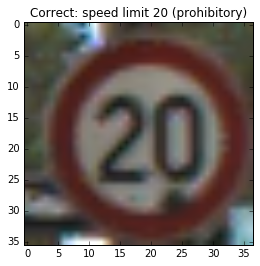

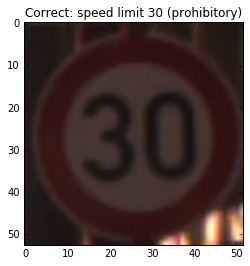

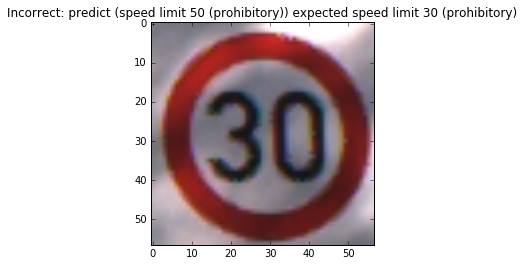

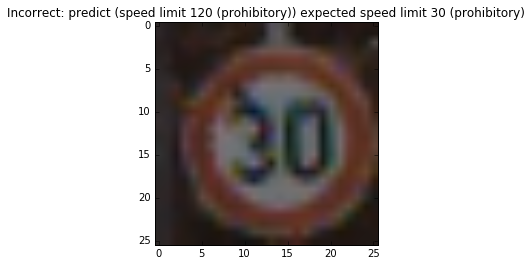

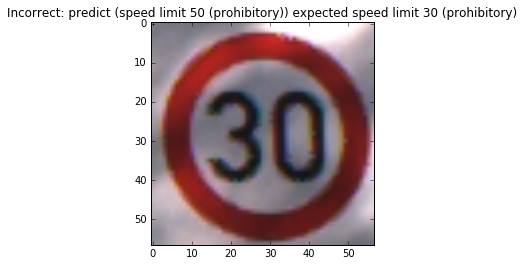

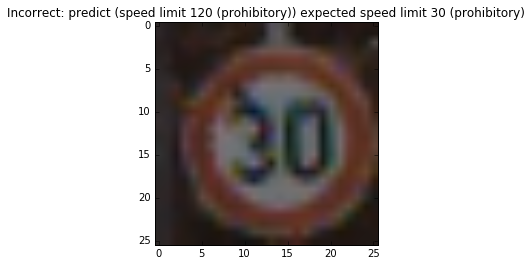

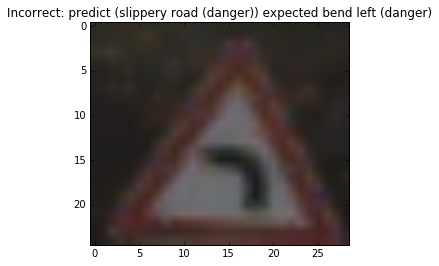

In [48]:
image_depth=1
tf.reset_default_graph() 
x = tf.placeholder(tf.float32, [None, 32, 32, image_depth],name="x")
y = tf.placeholder(tf.float32, [None,43],name="y")
rate = 0.003
logits = LeNet(x)
varss = tf.trainable_variables()
lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in varss
                   if '_b' not in v.name]) * 0.0001
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) + lossL2
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
    
with tf.Session() as sess:
	pathglobal = os.getcwd() + "/models/model3/saved/"
	saver.restore(sess, tf.train.latest_checkpoint(pathglobal))
	Xtest, Ytest = read_train_test_from_directory("images/test/")
	bk_Ytest=Ytest
	bk_Xtest=Xtest
	Xtest, Ytest = preprocess_data(Xtest, Ytest)
	predict_y = sess.run(logits, feed_dict={x: Xtest, y: Ytest})
	predict_y = np.argmax(predict_y,1)
	cont=0
	for i in range(len(predict_y)):
		if bk_Ytest[i]==predict_y[i]:
			plt.imshow(bk_Xtest[i])
			plt.title("Correct: "+label[bk_Ytest[i]])
			plt.show()
			cont=cont+1 
			if cont==2:
				break
	cont=0
	for i in range(len(predict_y)):
		if bk_Ytest[i]!=predict_y[i]:
			plt.imshow(bk_Xtest[i])
			plt.title("Incorrect: predict ("+label[predict_y[i]]+") expected "+label[bk_Ytest[i]])
			plt.show()
			cont=cont+1 
			if cont==5:
				break

# Inferences our model
To infer the model use this command - **python app.py infer -m model3 -d images/user**

In [49]:
def infer(m, d):
    print("Inference Phase - Path ",d)
    if d[-1]!='/':
        d=d+"/"

    if not os.path.exists("data/FullIJCNN2013/"):
        print("Please use first the next command (python app.py download)")
        return

    if not os.path.exists("images"):
        os.makedirs("images")
    if not os.path.exists("images/user"):
        os.makedirs("images/user")

    #get label of every class  (extracted from data/ReadMe.txt)
    label = get_label()
    label = np.array(label)
    Xinfer = []
    path_dir=d

    for file in os.listdir(path_dir):
        if os.path.isfile(os.path.join(path_dir, file)):
            if not file.endswith(".txt") and not file.endswith(".zip") \
                    and not file.endswith(".gzip") and not file.endswith(".md"):
                Xinfer.append(np.array(Image.open(os.path.join(path_dir, file))))
    Xinfer = np.array(Xinfer)
    _ = np.zeros(1)

    Xinfer, _ = preprocess_data(Xinfer, _)
    predictions = []

    if m == "model1":
        if not os.path.isfile("models/model1/saved/model1.sav"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model1 -d images/test)")
            return
        Xinfer = Xinfer.reshape([Xinfer.shape[0], -1])
        print("Task6: Inference in Logistic Regresion - Scikit")
        predictions = logistic_regression_scikit(d,False, 1, Xinfer)
        print(predictions)

    if m == "model2":
        if not os.path.isfile("models/model2/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model2 -d images/test)")
            return

        print("Task6: Inference in Logistic Regresion - Tensorflow")
        Xinfer = Xinfer.reshape([Xinfer.shape[0], -1])
        predictions = logistic_regression_tensorflow(d,False, 2, Xinfer)
        print(predictions)

    if m == "model3":
        if not os.path.isfile("models/model3/saved/checkpoint"):
            print("Does not exist, model trained")
            print("Please train first with the next command (python app.py test -m model3 -d images/test)")
            return
        print("Task6: Inference in LeNet Architecture - Tensorflow")
        predictions = lenet_tensorflow(d,False, 3, Xinfer)
        print(predictions)

    predictions = np.array(predictions)
    cont = 0

    for file in os.listdir(path_dir):
        if os.path.isfile(os.path.join(path_dir, file)):
            if not file.endswith(".txt") and not file.endswith(".zip") \
                    and not file.endswith(".gzip") and not file.endswith(".md"):
                filepath = path_dir + file
                txt = str("Class ")
                txt = txt + str(predictions[cont])
                txt = txt + str(": ")
                txt = txt + label[predictions[cont]]
                print("label: ", txt)
                x = plt.imread(filepath)
                plt.imshow(x)
                plt.title(txt)
                plt.show()
                cont = cont + 1

You must put your images for the prediction on the path **images/user**.
We download some images on the web to infer.

Inference Phase - Path  images/user
Task6: Inference in LeNet Architecture - Tensorflow
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\German Traffic Signs Detector/models/model3/saved/lenet.ckpt-500
[40 38 17 13]
label:  Class 40: roundabout (mandatory)


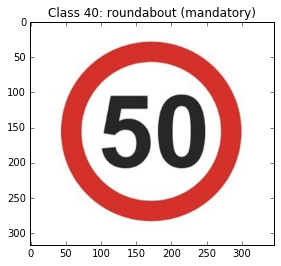

label:  Class 38: keep right (mandatory)


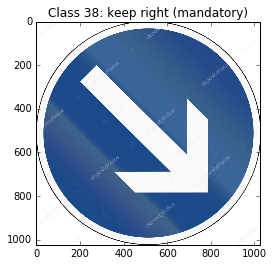

label:  Class 17: no entry (other)


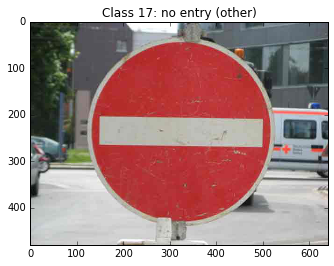

label:  Class 13: give way (other)


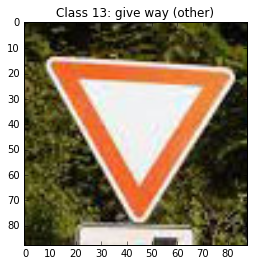

In [52]:
tf.reset_default_graph()
infer("model3","images/user")